# Clustering de documents

## Imports

In [2]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

In [3]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vkvvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
data_path = "../data/txt/"

## Choix d'une décennie

In [5]:
DECADE = '1900'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [6]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [7]:
# Exemple de fichiers
files[:5]

['KB_JB838_1900-01-02_01-00002.txt',
 'KB_JB838_1900-01-07_01-00007.txt',
 'KB_JB838_1900-01-08_01-00003.txt',
 'KB_JB838_1900-01-18_01-00008.txt',
 'KB_JB838_1900-01-19_01-00004.txt']

In [8]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [9]:
# Exemple de textes
texts[0][:400]

'La bretelle, sur les origines de laquelle le;- •pinions sont contradictoires, n’en remonte pa,> moins à une honorable antiquité. De tous temps, bien que sous des formes diverses, elle a servi à maintenir la culotte et, plus tard, le pantalon. Sous Louis-Philippe, elle eut même son heure de gloire. On la vit aux culottes-à-pont de la garde nationale, et le roi lui-méme, dans telles estampes recherc'

## Vectoriser les documents à l'aide de TF-IDF

In [10]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [11]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [12]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [13]:
# Détail de la matrice
tfidf_vectors
tfidf_vectors.shape

(1000, 3942)

### Imprimer le vecteur tf-IDF du premier document

In [14]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

janvier       0.289411
président     0.217008
dépêche       0.182851
anglaises     0.152892
guerre        0.143251
                ...   
découvert     0.000000
découverte    0.000000
découvrir     0.000000
décès         0.000000
♦             0.000000
Length: 3942, dtype: float64

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [15]:
N_CLUSTERS = 4

### Instancier le modèle K-Means et ses arguments

In [16]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [17]:
clusters = km_model.fit_predict(tfidf_vectors)

In [18]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [19]:
pprint(dict(clustering))

{0: ['KB_JB838_1900-01-18_01-00008.txt',
     'KB_JB838_1900-01-21_01-00008.txt',
     'KB_JB838_1900-01-28_01-00008.txt',
     'KB_JB838_1900-02-13_01-00003.txt',
     'KB_JB838_1900-04-26_01-00007.txt',
     'KB_JB838_1900-05-24_01-00008.txt',
     'KB_JB838_1900-06-07_01-00003.txt',
     'KB_JB838_1900-07-08_01-00008.txt',
     'KB_JB838_1900-07-27_01-00003.txt',
     'KB_JB838_1900-08-30_01-00003.txt',
     'KB_JB838_1900-09-20_01-00007.txt',
     'KB_JB838_1900-10-05_01-00003.txt',
     'KB_JB838_1900-11-18_01-00008.txt',
     'KB_JB838_1900-11-22_01-00008.txt',
     'KB_JB838_1900-11-26_01-00004.txt',
     'KB_JB838_1900-12-09_01-00008.txt',
     'KB_JB838_1901-02-07_01-00006.txt',
     'KB_JB838_1901-03-26_01-00003.txt',
     'KB_JB838_1901-03-31_01-00008.txt',
     'KB_JB838_1901-04-16_01-00003.txt',
     'KB_JB838_1901-04-18_01-00006.txt',
     'KB_JB838_1901-04-18_01-00008.txt',
     'KB_JB838_1901-04-27_01-00003.txt',
     'KB_JB838_1901-04-28_01-00006.txt',
     'KB_JB838_1

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [20]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [21]:
reduced_vectors[:10]

array([[-0.29863371, -0.18098933],
       [-0.16672903,  0.51822786],
       [-0.08271536,  0.10386054],
       [ 0.20097485,  0.26703697],
       [ 0.64203844, -0.24300442],
       [ 0.09443748,  0.21750647],
       [ 0.63832941, -0.26708496],
       [-0.31550701, -0.17332104],
       [ 0.03022567,  0.18802819],
       [-0.24407136,  0.10471284]])

### Générer le plot

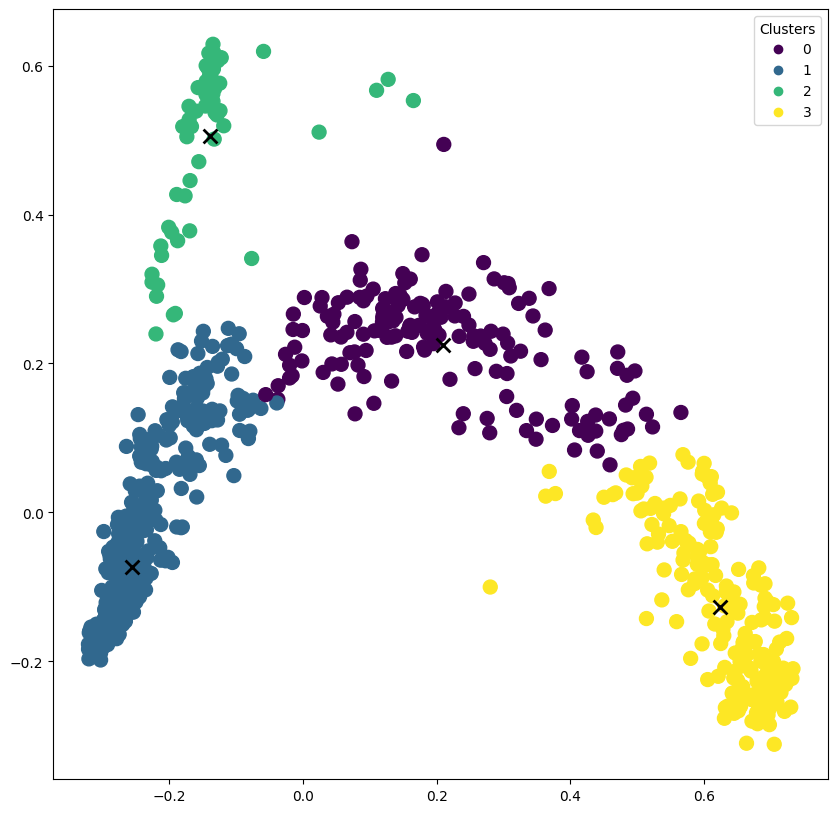

In [22]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Word Embeddings : le modèle Word2Vec

In [23]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [24]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

### Détection des bigrams

In [25]:
bigram_phrases = Phrases(sentences)

In [26]:
len(bigram_phrases.vocab.keys())

15850647

### Conversion des `Phrases` en objet `Phraser`

In [27]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

### Extraction des trigrams

In [28]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [29]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Création d'un corpus d'unigrams, bigrams, trigrams

In [30]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [31]:
print(corpus[:100])

[['mi', 'imnri', 'r', 'i', '<<', 'i', 'i', 'hmu', "'", 'i', '/', 'tx', "-'", 'l', ':', 'marche', 'tenu', 'hors', 'villa', ',', 'la', '9', '.'], ['--', 'u', 'a', 'ete', 'vaain', 'si', 'teicj', '>>', 'm', 'races_indigenes', 'de', 'fr', '.'], ['31', '<)', 'a', '5s', "'", 'k', '131', 'de', '.'], ['rasa', 'iichakdui', "'", 'te', ',', 'do', '(', 'r', '.', '3s0', 'h', '710', '.', 'taureaux', 'iallsenas', ',>', 'ia', 'u', '\\', '--', 'a', '--', ';', '0ii', '.'], ['hollandais', ',', 'dufr', '.'], ['0', '.'], ['--', 'a', '9', '.--', 'la', 'idto', '-', 'vachei', 'laitieres', ':', 'bn', 'vante', '1q', '.'], ['vendues', '3', '\\', 'au', 'prix', 'la', '410', 'a', '*', '<<', 'i', 'h', '\\;', 'genisses', ',', 'kl', '.'], ["'.", '9', '.'], ['i', 'l', '.', '2', 'i', '.', 'id', '.'], ['da', '370', 'i', '6lutr', '.'], ['marche', 'a', '<', 'u', 'porcs', '.'], ['--', 'categorie', 'de', 'lt', 'ilashtya', ':', "'", '237', 'on', 'vente', ';', 'vendus', '1', 'm', '.', 'do', "'", '2', 'i', '.--', 'a', ';:,', 'l'

## Entrainement d'un modèle Word2Vec sur ce corpus

In [32]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)
#commenceer avec une petite fenetre (1 ou 2), worker 1 ou 2 et epoque 1 pour tester puis augmenter au fur et à mesure
#faible distance et forte similarité

CPU times: total: 25min 39s
Wall time: 25min 39s


### Sauver le modèle dans un fichier

In [33]:
outfile = f"../data/newspapers_1900.model"
model.save(outfile)

## Explorer le modèle

In [35]:
model = Word2Vec.load("../data/newspapers_1900.model")

### Imprimer le vecteur d'un terme

In [41]:
model.wv["president"]

array([ -1.7686726 ,  -1.8004665 ,   4.615108  ,   1.153694  ,
        -5.6916733 ,   1.1761822 ,  -3.680175  ,  -2.7714386 ,
        -4.8930073 ,   0.59664196,   5.121529  ,   4.4661813 ,
         2.3596847 ,   0.8161718 ,   3.2129872 ,   4.964384  ,
        -4.9088516 ,  -0.35998875,   0.5502199 ,  -5.045709  ,
        -4.372826  ,  -3.2040892 ,   2.01828   ,  -6.182757  ,
        -2.5056164 ,  -2.9662387 ,  -0.7410506 ,   0.37290588,
         2.614983  ,  -6.2378955 , -10.771398  ,   0.7825158 ],
      dtype=float32)

### Calculer la similarité entre deux termes

In [42]:
model.wv.similarity("president", "roi")

0.7281126

In [48]:
model.wv.similarity("eruption", "ouragan")

0.74833304

In [49]:
model.wv.similarity("incendie", "catastrophe")

0.5881343

### Chercher les mots les plus proches d'un terme donné

In [43]:
model.wv.most_similar("president", topn=10)

[('secretaire_general', 0.9469814896583557),
 ('senateur', 0.9198275208473206),
 ('president_federal', 0.9134632349014282),
 ('conseiller', 0.9095914959907532),
 ('recteur', 0.9086315631866455),
 ('depute', 0.9021415710449219),
 ('president_national', 0.898239016532898),
 ('batonnier', 0.8934447765350342),
 ('secretaire_national', 0.8907942175865173),
 ('ministre', 0.884486734867096)]

In [45]:
model.wv.most_similar("roi", topn=10)

[('pape', 0.9067182540893555),
 ('roi_albert', 0.9037179946899414),
 ('tsar', 0.9035038948059082),
 ('shah', 0.8981012105941772),
 ('roi_leopold', 0.8972497582435608),
 ('sultan', 0.8969539403915405),
 ('prince', 0.8924431800842285),
 ('cardinal', 0.8903345465660095),
 ('marechal_foch', 0.8872212767601013),
 ('general_eisenhower', 0.8767974972724915)]

In [46]:
model.wv.most_similar("eruption", topn=10)

[('tornade', 0.8724731206893921),
 ('apparition', 0.8693287372589111),
 ('necropole', 0.8544681668281555),
 ('maree', 0.8518063426017761),
 ('epopee', 0.8425459861755371),
 ('orbite', 0.8378971219062805),
 ('averse', 0.8294404745101929),
 ('planete', 0.8284377455711365),
 ('flambee', 0.826991617679596),
 ('inondation', 0.8262530565261841)]

In [50]:
model.wv.most_similar("incendie", topn=10)

[('accident', 0.857582151889801),
 ('violent_incendie', 0.8414301872253418),
 ('explosion', 0.8278641700744629),
 ('orage', 0.7885528206825256),
 ('asphyxie', 0.7833660244941711),
 ('violent_orage', 0.77989262342453),
 ('attentat', 0.771946907043457),
 ('incident', 0.756906270980835),
 ('affreux_accident', 0.7534852623939514),
 ('deraillement', 0.7532265186309814)]

### Faire des recherches complexes à travers l'espace vectoriel

In [44]:
print(model.wv.most_similar(positive=['president', 'americain'], negative=['belgique']))

[('prussien', 0.8208644986152649), ('colonel_john', 0.8084596395492554), ('republicain', 0.7916713953018188), ('comte_adrien_van_der', 0.765486478805542), ('grec', 0.7604077458381653), ('sir_john', 0.7580713629722595), ('mohamed', 0.7536551356315613), ('secretaire_parlementaire', 0.7513039112091064), ('juriste', 0.748174250125885), ('goebbels', 0.7386553883552551)]


In [54]:
print(model.wv.most_similar(positive=['incendie', 'catastrophe'], negative=['humain']))

[('nuit_derniere', 0.8037353157997131), ('collision', 0.7632569670677185), ('police_judiciaire', 0.7467846274375916), ('gendarmerie', 0.731993556022644), ('explosion', 0.7278656363487244), ('police', 0.7261945009231567), ('brigade_mobile', 0.725778341293335), ('greve', 0.716828465461731), ('police_locale', 0.7116406559944153), ('une_collision', 0.7099238038063049)]
